# Proyecto Integrador

## Score de Riesgo en Originación de Crédito
## Para Kubo Financiero

Participantes:

Dalina Aideé Villa Ocelotl (A01793258)

Julián Valera Juarez (A01793875)

Miguel Guillermo Galindo Orozco (A01793695)
1793695)

## Avance 4. Modelos alternativos

### Importar librerías

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

### Leer datos

In [ ]:
file_path = '/content/base_20210101a20240430 (2).xlsx'
df = pd.read_excel(file_path, sheet_name='Cliientes_Nuevos')

Eliminar variables no necesarias

In [ ]:
variables_eliminar = ["montocredito_actual", "estatus_actual","diasatraso_actual","saldo_actual"]
variables_ok = [i for i in df.columns if i not in variables_eliminar ]
df = df[variables_ok]
df = df[df['es_malo_actual'].isin([0,1])]
df = df.dropna()

Separar variables independientes (x) y dependientes (y)

In [ ]:
y = df['es_malo_actual']
X = df.drop(['es_malo_actual'], axis=1)

Eliminar columnas datetime y convertir categorias en dummy

In [ ]:
X = X.select_dtypes(exclude=['datetime64'])
X = pd.get_dummies(X, drop_first=True)

Escalar datos

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Separar conjuntos de entrenamiento (train) y prueba (test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1234, shuffle=True)

## **Entrenamiento de modelos**

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_probs)
    acc_score = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"ROC-AUC Score: {auc_score}")
    print(f"Accuracy Score: {acc_score}")
    print("Classification Report:")
    print(class_report)

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Malo', 'Malo'], yticklabels=['No Malo', 'Malo'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return auc_score, acc_score

Se entrenan los distintos modelos con sus métricas de performance

Evaluating Logistic Regression...
ROC-AUC Score: 0.6491401594466716
Accuracy Score: 0.796048891415577
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      5614
           1       0.30      0.01      0.01      1422

    accuracy                           0.80      7036
   macro avg       0.55      0.50      0.45      7036
weighted avg       0.70      0.80      0.71      7036



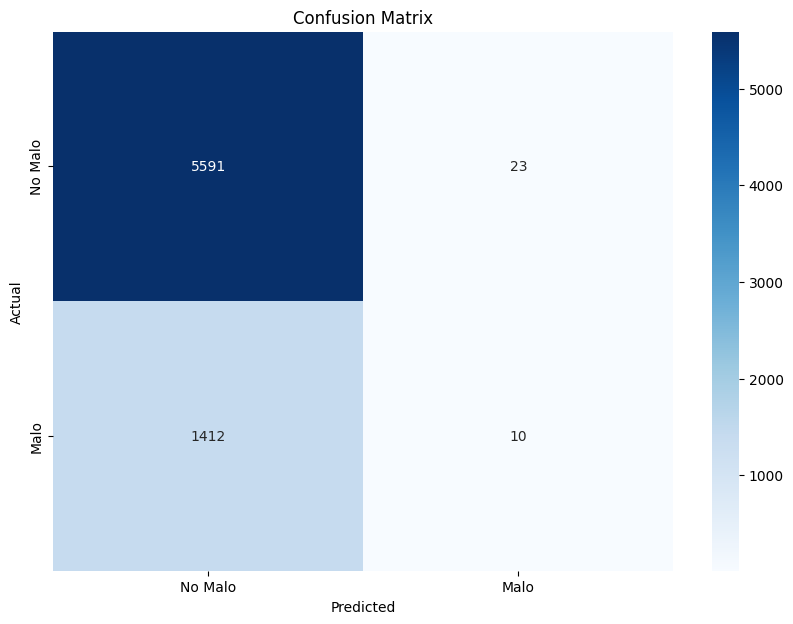

Evaluating Random Forest...
ROC-AUC Score: 0.6808189241583603
Accuracy Score: 0.7984650369528141
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      5614
           1       0.55      0.02      0.03      1422

    accuracy                           0.80      7036
   macro avg       0.67      0.51      0.46      7036
weighted avg       0.75      0.80      0.71      7036



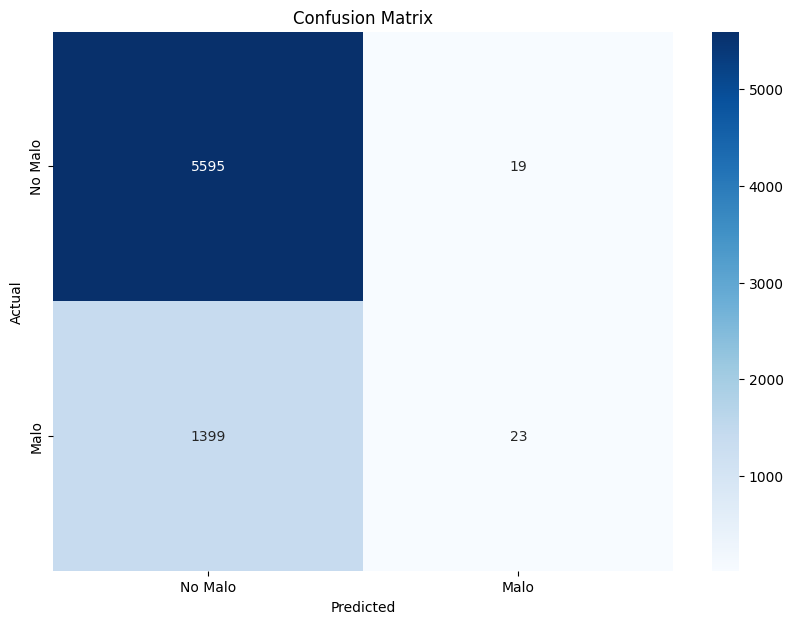

Evaluating Gradient Boosting...
ROC-AUC Score: 0.6976905485933549
Accuracy Score: 0.7984650369528141
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      5614
           1       0.56      0.01      0.03      1422

    accuracy                           0.80      7036
   macro avg       0.68      0.51      0.46      7036
weighted avg       0.75      0.80      0.71      7036



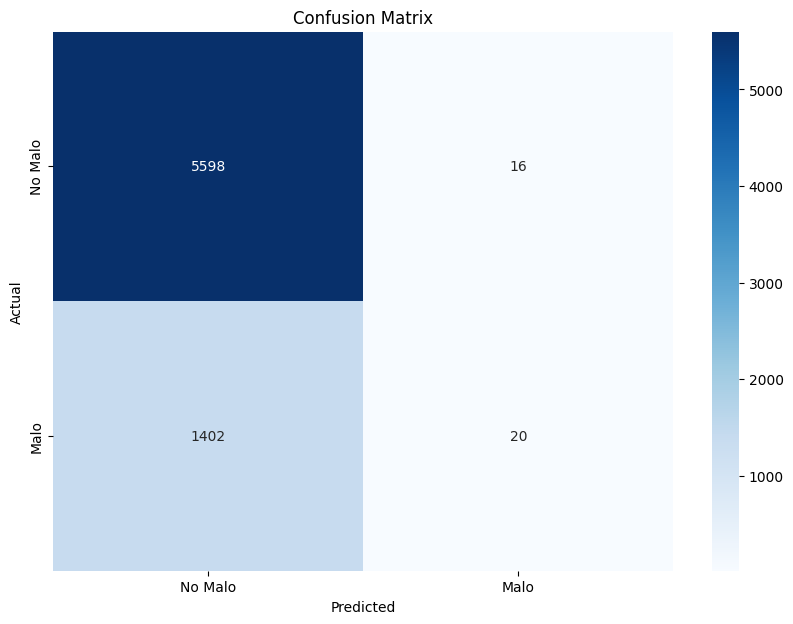

Evaluating Support Vector Machine...


KeyboardInterrupt: 

In [23]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

model_performance = {}

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    auc_score, acc_score = evaluate_model(model, X_train, y_train, X_test, y_test)
    model_performance[model_name] = {'ROC-AUC': auc_score, 'Accuracy': acc_score}

Comparación de resultados de modelos

In [ ]:
performance_df = pd.DataFrame(model_performance).T
print(performance_df)

                         ROC-AUC  Accuracy
Logistic Regression     0.649140  0.796049
Random Forest           0.684136  0.798749
Gradient Boosting       0.697627  0.798465
Support Vector Machine  0.581105  0.797328
K-Nearest Neighbors     0.558248  0.762933
Naive Bayes             0.593184  0.714895


Selecciona los dos modelos con mejor ROC-AUC

In [ ]:
 top_2_models = performance_df.nlargest(2, 'ROC-AUC')
print("\nModels Based on ROC-AUC:")
print(top_2_models)


Models Based on ROC-AUC:
                    ROC-AUC  Accuracy
Gradient Boosting  0.697627  0.798465
Random Forest      0.684136  0.798749


Ajuste de hiperparámetros a los dos mejores modelos (Gradient Boosting (gb) y Random Forest (rf))


Usamos GridSearchCV para busqueda en grid con validación cruzada (cv=5) para encontrar la mejor combinación de hiperparámetros

In [44]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='roc_auc')
grid_gb = GridSearchCV(GradientBoostingClassifier(), param_grid_gb, cv=5, scoring='roc_auc')

Entrenamos los modelos ajustados

In [45]:
print("Ajustando hiperparámetros para Random Forest...")
grid_rf.fit(X_train, y_train)
print("Ajustando hiperparámetros para Gradient Boosting...")
grid_gb.fit(X_train, y_train)

Ajustando hiperparámetros para Random Forest...


KeyboardInterrupt: 

Evaluar modelos ajustados


Evaluación del modelo Random Forest ajustado:
ROC-AUC Score: 0.692477666593011
Accuracy Score: 0.797896532120523
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      5614
           1       0.00      0.00      0.00      1422

    accuracy                           0.80      7036
   macro avg       0.40      0.50      0.44      7036
weighted avg       0.64      0.80      0.71      7036



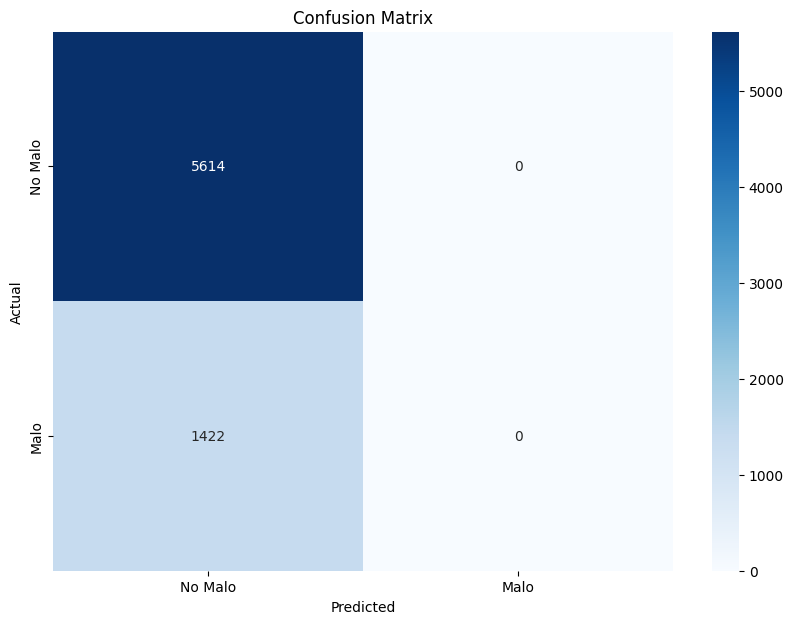


Evaluación del modelo Gradient Boosting ajustado:
ROC-AUC Score: 0.6958234812807242
Accuracy Score: 0.799175667993178
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      5614
           1       0.57      0.03      0.05      1422

    accuracy                           0.80      7036
   macro avg       0.69      0.51      0.47      7036
weighted avg       0.75      0.80      0.72      7036



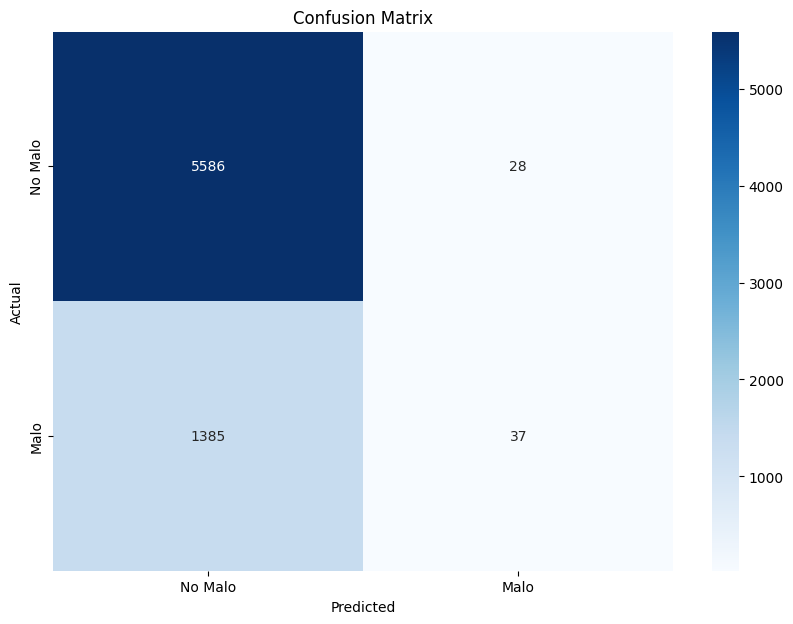

(0.6958234812807242, 0.799175667993178)

In [ ]:
print("\nEvaluación del modelo Random Forest ajustado:")
evaluate_model(grid_rf.best_estimator_, X_train, y_train, X_test, y_test)
print("\nEvaluación del modelo Gradient Boosting ajustado:")
evaluate_model(grid_gb.best_estimator_, X_train, y_train, X_test, y_test)

Modelo final con mejor rendimiento

In [ ]:
rf_best_score = grid_rf.best_score_
gb_best_score = grid_gb.best_score_
modelo_final = ''

print(f"Mejor score de Random Forest: {rf_best_score}")
print(f"Mejor score de Gradient Boosting: {gb_best_score}")

if rf_best_score > gb_best_score:
    # final_model = grid_rf.best_estimator_
    modelo_final = "Random Forest"
else:
    # final_model = grid_gb.best_estimator_
    modelo_final = "Gradient Boosting"
print(f"\nEl mejor modelo es: {modelo_final}")

Mejor score de Random Forest: 0.6806720533637354
Mejor score de Gradient Boosting: 0.6820382731048896

El mejor modelo es: Gradient Boosting


### **El mejor modelo es Gradient Boosting.**

### **Por lo que ahora, buscaremos optimizar sobre ese algoritmo.**

Lo que proponemos es aplicar una optimización del mismo conocido como **XGBoost (eXtreme Gradient Boosting)**, este algoritmo a diferencia del Gradient Boosting simple, permite optimizar en distintos hiperparámetros buscando optimizaciones globales y no sólo locales, algunos de las principales diferencias que marcan un beneficio son:

- Regularización: Permite aplicar regularización para evitar overfitting.
- Computo paralelizado: Permite realizar computo por batches de información.
- Se puede trabajar con información faltante (missing data)
- Tree Prunning: Realizar optimización de los árboles para encontrar mínimos globales y no sólo locales.
- Validación Cruzada desde el entrenamiento.


#### Librerías a utilizar

In [26]:
from sklearn.inspection import permutation_importance
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import shap



ModuleNotFoundError: No module named 'shap'

In [30]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.early_stop import no_progress_loss

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [28]:
from sklearn.metrics import precision_recall_curve
#from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score



In [27]:

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import VotingClassifier

Iniciamos el espacio de búscada con rangos para encontrar los mejores parámetros para el XGBoost

In [31]:
space={
        'max_depth': hp.quniform("max_depth", 3, 25, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,10),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 15, 1),
        'n_estimators': hp.quniform('n_estimators', 2500,15000,25),
        'scale_pos_weight': hp.quniform('scale_pos_weight', 2,15,1), # Hiperparámetro de pesos para balance de clases
        'seed': 0
    }

### Definir función objetivo para la optimización (minimización del -roc_auc)
### Optimización bayesiana (tuneada de hiperparámetros)


In [32]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =int(space['n_estimators']),
                    max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = space['reg_alpha'],
                    min_child_weight=int(space['min_child_weight']),
                    scale_pos_weight=int(space['scale_pos_weight']),
                    colsample_bytree=int(space['colsample_bytree']))

    evaluation = [( X_train, y_train), ( X_test, y_test)]

    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="aucpr",
            early_stopping_rounds=10,verbose=False)


    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    ns_auc = roc_auc_score(y_test,  pred>0.5)
    precision = precision_score(y_test,  pred)
    recall = recall_score(y_test,  pred)
    f1 = f1_score(y_test,  pred)
    print ("Accuracy:", accuracy, " ROC_AUC:",ns_auc, "precision:", precision, "f1:",f1)
    print ("------------------------------------")
    return {'loss': -f1, 'status': STATUS_OK }

### Algoritmo de optimización

Este proceso puede ser tardado.

Eliminamos la impresión de los 500 resultados solicitados.

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 500,
                        trials = trials,
                        early_stop_fn = no_progress_loss(200))

### Mejores resultados con la optimización

In [33]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  



NameError: name 'best_hyperparams' is not defined

In [34]:
%%time

xgb_params = {'n_estimators': best_hyperparams['n_estimators'],
                    'max_depth': int(best_hyperparams['max_depth']),
                    'gamma': best_hyperparams['gamma'],
                    'reg_alpha': best_hyperparams['reg_alpha'],
                    'reg_lambda': best_hyperparams['reg_lambda'],
                    'min_child_weight': int(best_hyperparams['min_child_weight']),
                    'scale_pos_weight': int(best_hyperparams['scale_pos_weight']),
                    'colsample_bytree': int(best_hyperparams['colsample_bytree'])}



NameError: name 'best_hyperparams' is not defined

In [ ]:
xgb_params

### Entrenamos un XGBoost con los mejores parámetros encontrados

In [35]:
model = xgb.XGBClassifier(
                                n_estimators = 13025,
                                max_depth= 11,
                                gamma = 3.0352011179155465,
                                reg_alpha = 45.0,
                                reg_lambda = 1.9061745700892092,
                                min_child_weight = 1,
                                scale_pos_weight = 4,
                                colsample_bytree = 0,
                                seed = 1234)

In [37]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3.0352011179155465,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=13025, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Resultados encontrados y evalaución del modelo

ROC-AUC Score: 0.6884571146976842
Accuracy Score: 0.5947981807845367
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.57      0.69      5614
           1       0.29      0.69      0.41      1422

    accuracy                           0.59      7036
   macro avg       0.58      0.63      0.55      7036
weighted avg       0.76      0.59      0.63      7036



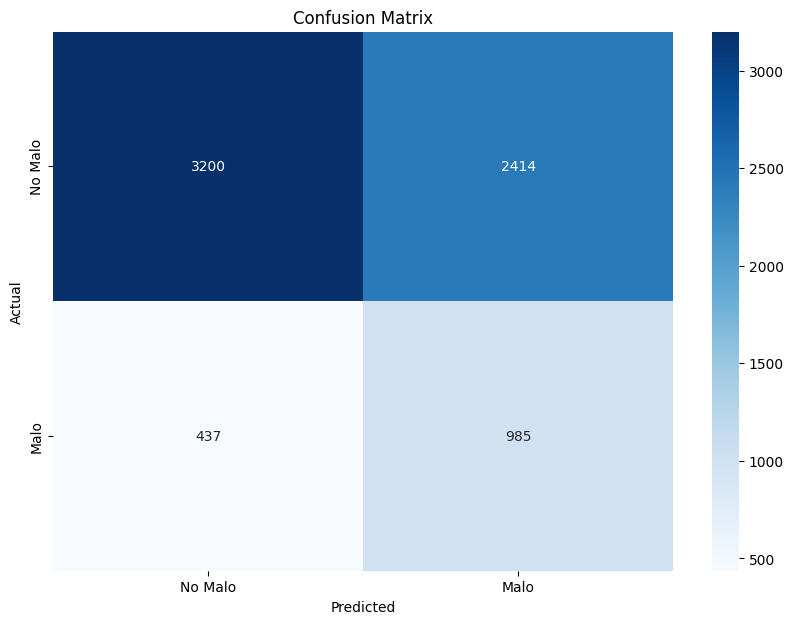

In [38]:
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_probs)
acc_score = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"ROC-AUC Score: {auc_score}")
print(f"Accuracy Score: {acc_score}")
print("Classification Report:")
print(class_report)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Malo', 'Malo'], yticklabels=['No Malo', 'Malo'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

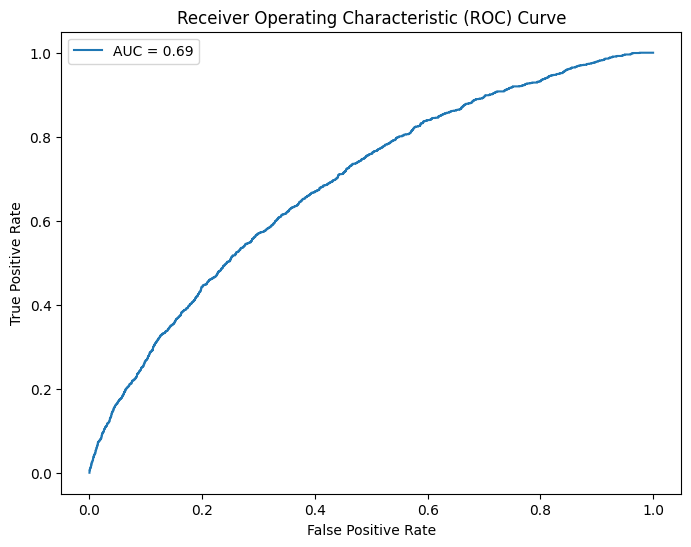

In [39]:
# Calcular la curva ROC y AUC-ROC
from sklearn.metrics import auc
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

Precisión y Recall:

Para la clase 0, el modelo tiene alta precisión (0.88) pero un recall moderado (0.58). Esto indica que cuando el modelo predice clase 0, es correcto el 88% del tiempo, pero solo identifica el 58% de todas las instancias reales de clase 0.
Para la clase 1, el modelo tiene baja precisión (0.30) pero alto recall (0.70). Esto significa que cuando el modelo predice clase 1, identifica el 70% de todas las instancias reales de clase 1.

**Anexo Modelo ensamble**

ROC-AUC Score: 0.6742937690203316
Accuracy Score: 0.7768618533257533
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      5632
           1       0.38      0.18      0.24      1404

    accuracy                           0.78      7036
   macro avg       0.60      0.55      0.56      7036
weighted avg       0.73      0.78      0.74      7036



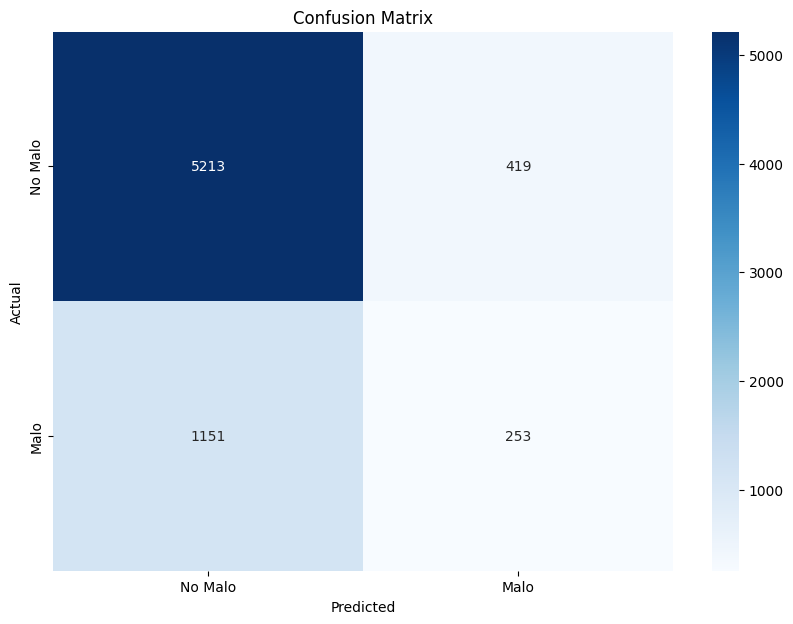

In [43]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


# Modelo ensamble con el modelo final y un RF
ensemble_model = VotingClassifier(estimators=[('rf', rf_model), ('xgb', model)], voting='soft')
ensemble_model.fit(X_train, y_train)

y_pred = ensemble_model.predict(X_test)
y_probs = ensemble_model.predict_proba(X_test)[:, 1]

# Métricas de rendimiento
auc_score = roc_auc_score(y_test, y_probs)
acc_score = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"ROC-AUC Score: {auc_score}")
print(f"Accuracy Score: {acc_score}")
print("Classification Report:")
print(class_report)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Malo', 'Malo'], yticklabels=['No Malo', 'Malo'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


ROC-AUC Score: 0.6637186417459855
Accuracy Score: 0.761654349061967
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      5632
           1       0.33      0.20      0.25      1404

    accuracy                           0.76      7036
   macro avg       0.58      0.55      0.55      7036
weighted avg       0.72      0.76      0.74      7036



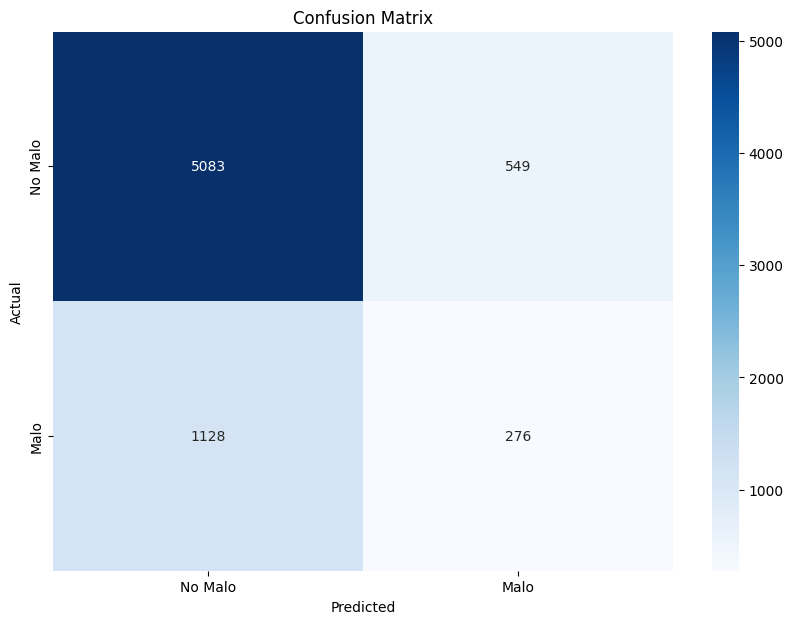

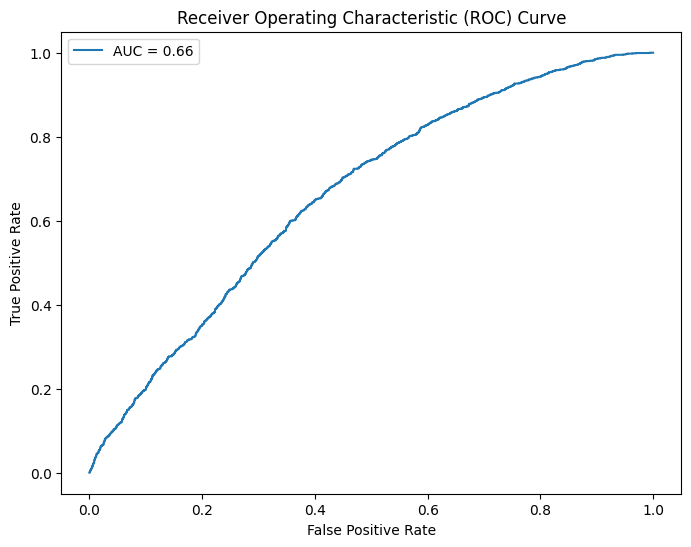

In [50]:

xgb_selector = xgb.XGBClassifier()
xgb_selector.fit(X_train, y_train)
selector = SelectFromModel(xgb_selector, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Hiperparámetros para los modelos en el ensamblado
params1 = {
    'n_estimators': 1000,
    'max_depth': 6,
    'learning_rate': 0.1,
    'gamma': 0,
    'reg_alpha': 1,
    'reg_lambda': 1,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'scale_pos_weight': 1,
    'seed': 1234
}

params2 = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# modelo ensamble con el modelo final y otro XGB
model1 = xgb.XGBClassifier(**params1)
model2 = xgb.XGBClassifier(**params2)

ensemble_model = VotingClassifier(estimators=[
    ('xgb1', model1),
    ('xgb', model)], voting='soft')

ensemble_model.fit(X_train_selected, y_train)

y_pred = ensemble_model.predict(X_test_selected)
y_probs = ensemble_model.predict_proba(X_test_selected)[:, 1]

# Evaluaciones
auc_score = roc_auc_score(y_test, y_probs)
acc_score = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"ROC-AUC Score: {auc_score}")
print(f"Accuracy Score: {acc_score}")
print("Classification Report:")
print(class_report)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Malo', 'Malo'], yticklabels=['No Malo', 'Malo'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calcular la curva ROC y AUC-ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# **Conclusiones**

En el presente Notebook probamos distintos modelos alternativos para la data de colocación de crédito en originación de Kubo Financiero.

Entre los modelos alternativos (algoritmos) que probamos se encuentran:

*   **Logistic Regression**  
*   **Random Forest**  
*   **Gradient Boosting**
*   **Support Vector Machine**
*   **K-Nearest Neighbors**  
*   **Naive Bayes**  

Con lo anterior, los dos mejores modelos encontrados fueron:

**Random Forest y Gradient Boosting.**

Que cuando aplicamos un gridSearch para optimizar parámetros, encontramos que el mejor de ellos es el Gradient Boosting.

Con el resultado anterior, lo que decidimos fue aplicar un XGBoost, una optimización del Gradient Boosting, que nos permite penalizar por overfitting, optimizar el cálculo con computo paralelizado, encontrar optimos globales, entre otros.

Con lo que encontramos un modelo final:

**XGBoost (eXtreme Gradient Boosting)** con ROC = 69 (que es nuestra métrica de interes)

Adicional se hizo prueba de ese modelo con un ensamble con el modleo final, pero el resultado se confirma que sigue siendo mejor el modelo de XGBoost